# Heart rates of all adult patients
We would like to create a histogram of all adult (age >= 16) patients’ heart rates. Heart rates are registered as two separate charted events , under the label ‘Heart rate’, or with unique identifiers 211 and 220045. 

### SQL query description
To get all adult patients’ heart rates, we first combine the Patients and Admissions tables again to get the age of each patient (computed from each patient’s date of birth and hospital admission time). We filter out all patients younger than 16 years old, and select the values from the charted events related to the unique identifiers mentioned above, or in the diagram. 

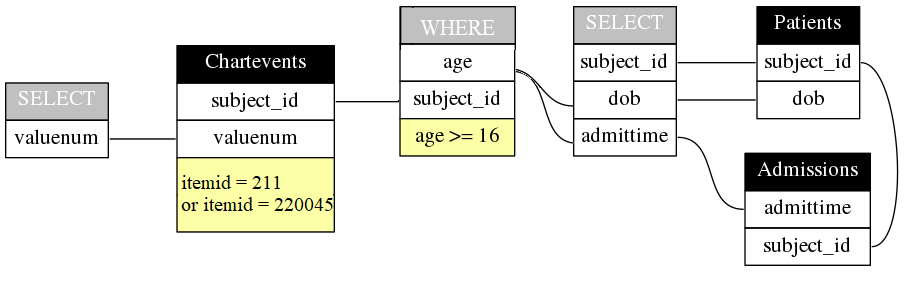

In [1]:
from IPython.display import Image
Image("../cookbook_queries/SQL_query_diagrams/heart_rate.png", width=700)

### Implementation of the above query
For the implementation, we will need to filter on charted events with item ID 211 or 220045, which both correspond to heart rate.

In [5]:
# Imports:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import colorsys
import psycopg2
%matplotlib inline

# Configuration:
sqluser = 'postgres'
dbname = 'mimic'
password='postgres'
schema_name = 'mimiciii'

# Connect to MIMIC-III:
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [6]:
# Make sure that we are looking at the right item IDs:
query =  """
SELECT d.itemid, d.label
FROM mimiciii.d_items d
WHERE d.label LIKE '%Heart Rate%'
"""
query_output = pd.read_sql_query(query,con)
query_output

,itemid,label
0,211,Heart Rate
1,3494,Lowest Heart Rate
2,220045,Heart Rate
3,220047,Heart Rate Alarm - Low


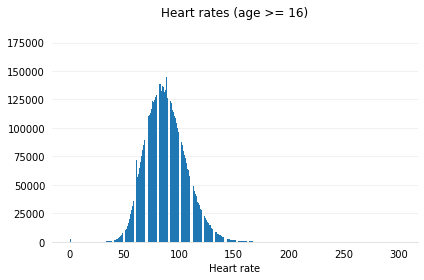

In [8]:
query = """
WITH subjects_above16 AS
(
  SELECT a.subject_id
  FROM mimiciii.admissions a
  INNER JOIN mimiciii.patients p
  ON a.subject_id = p.subject_id
  WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
  group by a.subject_id
)
, heart_rate_table as
(
  SELECT width_bucket(ce.valuenum, 0, 300, 301) AS bucket
  FROM mimiciii.chartevents ce
  INNER JOIN subjects_above16
  ON ce.subject_id = subjects_above16.subject_id
  WHERE ce.itemid in (211, 220045)
)
SELECT bucket as heart_rate, count(*)
FROM heart_rate_table
GROUP BY bucket
ORDER BY bucket;
"""

query_output = pd.read_sql_query(query,con)

# Visualize:
fig, ax = plt.subplots()
bars = ax.bar(query_output['heart_rate'], query_output['count'])
plt.xlabel('Heart rate')
plt.title('Heart rates (age >= 16)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

bar_color = bars[0].get_facecolor()
plt.tight_layout()
fig.savefig('figures/heart_rate_histogram.jpg', dpi=400)